# Process data

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import random
import glob
import umap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='once')

from ggplot import *

from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Data

Two datasets were downloaded from ADAGE repository [ADAGE](https://github.com/greenelab/adage) based on work from [Tan et. al.](https://msystems.asm.org/content/1/1/e00025-15).  Below is a description of the two datasets and how they were generated:  

```
data 
```
1. Gene expression quantification raw data based on Affymetrix GeneChip was downloaded from ArrayExpress.
2. Use [RMA](https://www.rdocumentation.org/packages/affy/versions/1.50.0/topics/rma) bioconductor library to convert raw array data to log 2 gene expression data.
3. Only keep PA genes, remove control genes

```
normalized_data
```
1. Use data from above
2. Normalize each gene to be between 0 and 1

## About Affymetrix GeneChip processing

**Measurements**
mRNA samples samples are labeled with flouresence and hybridized to GeneChip probe array.  The probe array is then scanned and the flouresence intensity of each probe (or feature) is measured.  A trasncript is represented by a probe set (~11-20 pairs of probes - see explanation of pairs below).  The probe set intensity forms the expression measure for a given transcript.

**Array Design**
Two probes: 1) probe is completely complementary to target sequence, perfect match probe (PM) and 2) probe contains a single mismatch to the target sequence in the middle of the probe, mismatch probe(MM).  A probe pair is (PM, MM)  

from [The Affymetrix GeneChip Platform: An Overview](https://www.sciencedirect.com/science/article/pii/S0076687906100014?via%3Dihub#fig0001)

**Robust multiarray average (rma)**

1. Assuming PM = background + signal we want to correct for background signal, returns E[signal|background+signal] assuming signal~exponential and background~normal.
2. Use quantile normalization is to make the distribution of probe intensities the same across arrays.  The steps are 1) for each array, rank the probe intensity from lowest to highest, 2) For each array rearrange probe intensity values from lowest to highest, 3) Take the average across arrays for each probe and asssign rank, 4) replace ranks from (1) with mean values.  Example from [Quantile Normalization wiki](https://en.wikipedia.org/wiki/Quantile_normalization)   
3. Calculating the probe set intensity by averaging PM-MM across probes in probe set and log2 transform, Y.  Fit regression model to Y (probe set intensity) = probe affinity effect + *log scale expression level* + error

from [Exploration, normalization, and summaries of high density oligonucleotide array probe level data](https://academic.oup.com/biostatistics/article/4/2/249/245074)

**Alternative normalization methods**

In [2]:
# Load arguments
data_file = os.path.join(
    os.path.dirname(os.getcwd()),
    "data",
    "input",
    "Pa_compendium_02.22.2014.pcl")

normalized_data_file = os.path.join(
    os.path.dirname(os.getcwd()),
    "data",
    "input",
    "train_set_normalized.pcl")

metadata_file = os.path.join(
    os.path.dirname(os.getcwd()),
    "data",
    "metadata",
    "sample_annotations.tsv")

In [3]:
# Read in data
data = pd.read_table(data_file, header=0, sep='\t', index_col=0).T
data.head(5)

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
05_PA14000-4-2_5-10-07_S2.CEL,9.620090,10.575783,9.296287,9.870074,8.512268,7.903954,7.039473,10.209826,9.784684,5.485688,...,7.740609,9.730384,10.516061,10.639916,9.746849,5.768592,9.224442,11.512176,12.529719,11.804896
54375-4-05.CEL,9.327996,10.781977,9.169988,10.269239,7.237999,7.663758,6.855194,9.631573,9.404465,5.684067,...,7.127736,9.687607,10.199612,9.457152,9.318372,5.523898,7.911031,10.828271,11.597643,11.268520
AKGlu_plus_nt_7-8-09_s1.CEL,9.368599,10.596248,9.714517,9.487155,7.804147,7.681754,6.714411,9.497601,9.523126,5.766331,...,7.343241,9.717993,10.419979,10.164667,10.305005,5.806817,8.575730,10.858250,12.255953,11.309662
anaerobic_NO3_1.CEL,9.083292,9.897050,8.068471,7.310218,6.723634,7.141148,8.492302,7.740717,7.640251,5.267993,...,7.374740,8.287819,9.437053,8.936576,9.418147,5.956482,7.481406,7.687985,9.205525,9.395773
anaerobic_NO3_2.CEL,8.854901,9.931392,8.167126,7.526595,6.864015,7.154523,8.492109,7.716687,7.268094,5.427256,...,7.425398,8.588969,9.313851,8.684602,9.272818,5.729479,7.699086,7.414436,9.363494,9.424762


In [4]:
# Read in data
normalized_data = pd.read_table(
    normalized_data_file, 
    header=0, 
    sep='\t', 
    index_col=0).T

normalized_data.head(5)

Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
05_PA14000-4-2_5-10-07_S2.CEL,0.853357,0.725280,0.640617,0.811465,0.694460,0.533958,0.158865,0.889579,0.884945,0.176558,...,0.466871,0.702785,0.790965,0.893249,0.789939,0.164157,0.970470,0.887472,0.900484,0.880012
54375-4-05.CEL,0.778790,0.767873,0.614859,0.907865,0.398800,0.460849,0.113876,0.761351,0.801740,0.222709,...,0.352020,0.694387,0.733186,0.639074,0.681204,0.110301,0.619554,0.747656,0.749893,0.805374
AKGlu_plus_nt_7-8-09_s1.CEL,0.789155,0.729508,0.725913,0.718989,0.530160,0.466327,0.079507,0.731643,0.827707,0.241847,...,0.392405,0.700352,0.773422,0.791118,0.931585,0.172570,0.797148,0.753785,0.856253,0.811099
anaerobic_NO3_1.CEL,0.716320,0.585079,0.390211,0.193248,0.279456,0.301781,0.513547,0.342051,0.415668,0.125914,...,0.398308,0.419574,0.593955,0.527203,0.706524,0.205510,0.504767,0.105662,0.363409,0.544780
anaerobic_NO3_2.CEL,0.658015,0.592172,0.410331,0.245504,0.312028,0.305852,0.513499,0.336723,0.334226,0.162965,...,0.407801,0.478697,0.571460,0.473054,0.669643,0.155548,0.562927,0.049738,0.388931,0.548814


In [5]:
# Read in metadata
metadata = pd.read_table(
    metadata_file, 
    header=0, 
    sep='\t', 
    index_col='ml_data_source')

metadata.head(10)

,experiment,sample_name,description,nucleic_acid,medium,genotype,od,growth_setting_1,growth_setting_2,strain,temperature,treatment,additional_notes,variant_phenotype,abx_marker,biotic_int_lv_2,biotic_int_lv_1
ml_data_source,,,,,,,,,,,,,,,,,
GSM1141730_PA01_ZnO_PZO_.CEL,E-GEOD-46947,GSM1141730 1,Pseudomonas aeruginosa PAO1 LB aerated 5 h wi...,RNA,LB,NaN,NaN,planktonic,aerated,PAO1,37.0,1 mM ZnO nanoparticles,Grown for 5h,NaN,NaN,NaN,NaN
GSM1141729_PA01_none_PC_.CEL,E-GEOD-46947,GSM1141729 1,Pseudomonas aeruginosa PAO1 LB aerated 5 h,RNA,LB,NaN,NaN,planktonic,aerated,PAO1,37.0,NaN,Grown for 5h,NaN,NaN,NaN,NaN
GSM1608059_Planktonic_1.CEL,E-GEOD-65882,GSM1608059 1,PAO1 WT. Planktonic. Rep1,RNA,PBM plus 1 g / L glucose.,WT,0.26,Planktonic,Aerated,PAO1,37.0,NaN,Grown shaking at 200rpm,NaN,NaN,NaN,NaN
GSM1608060_Planktonic_2.CEL,E-GEOD-65882,GSM1608060 1,PAO1 WT. Planktonic. Rep2,RNA,PBM plus 1 g / L glucose.,WT,0.26,Planktonic,Aerated,PAO1,37.0,NaN,Grown shaking at 200rpm,NaN,NaN,NaN,NaN
GSM1608061_Planktonic_3.CEL,E-GEOD-65882,GSM1608061 1,PAO1 WT. Planktonic. Rep3,RNA,PBM plus 1 g / L glucose.,WT,0.26,Planktonic,Aerated,PAO1,37.0,NaN,Grown shaking at 200rpm,NaN,NaN,NaN,NaN
GSM1608062_Planktonic_4.CEL,E-GEOD-65882,GSM1608062 1,PAO1 WT. Planktonic. Rep4,RNA,PBM plus 1 g / L glucose.,WT,0.26,Planktonic,Aerated,PAO1,37.0,NaN,Grown shaking at 200rpm,NaN,NaN,NaN,NaN
GSM1608067_Biofilm+12hrcipro_rep1.CEL,E-GEOD-65882,GSM1608067 1,"P. aeruginosa PAO1, cells grown 72 hours in a ...",RNA,PBM supplemented with 0.2 g/L glucose,WT,NaN,Biofilm,drip-flow biofilm reactor,PAO1,37.0,12h treatment with ciprofloxacin at 1.0 μg/ml,12 hours; stainless steel slides; 10o incline;...,NaN,NaN,NaN,NaN
GSM1608068_Biofilm+12hrcipro_rep2.CEL,E-GEOD-65882,GSM1608068 1,"P. aeruginosa PAO1, cells grown 72 hours in a ...",RNA,PBM supplemented with 0.2 g/L glucose,WT,NaN,Biofilm,drip-flow biofilm reactor,PAO1,37.0,12h treatment with ciprofloxacin at 1.0 μg/ml,12 hours; stainless steel slides; 10o incline;...,NaN,NaN,NaN,NaN
GSM1608069_Biofilm+12hrcipro_rep3.CEL,E-GEOD-65882,GSM1608069 1,"P. aeruginosa PAO1, cells grown 72 hours in a ...",RNA,PBM supplemented with 0.2 g/L glucose,WT,NaN,Biofilm,drip-flow biofilm reactor,PAO1,37.0,12h treatment with ciprofloxacin at 1.0 μg/ml,12 hours; stainless steel slides; 10o incline;...,NaN,NaN,NaN,NaN


## Select metadata field

In [6]:
# Select metadata field
# Choices:  medium
#           strain
#           growth_setting_1
#           experiment
metadata_field = 'growth_setting_1'
metadata_selected = metadata[metadata_field].to_frame()

metadata_selected.head(5)

,growth_setting_1
ml_data_source,
GSM1141730_PA01_ZnO_PZO_.CEL,planktonic
GSM1141729_PA01_none_PC_.CEL,planktonic
GSM1608059_Planktonic_1.CEL,Planktonic
GSM1608060_Planktonic_2.CEL,Planktonic
GSM1608061_Planktonic_3.CEL,Planktonic


In [7]:
# Select subset of values within metadata field
if metadata_field == 'experiment':
    metadata_selected_labeled = metadata_selected

if metadata_field == 'strain':
    values = ['PAO1', 'PA14', 'CF sputum isolate']
    # Re-label metadata field based on subset of values
    metadata_vector = metadata[metadata_field]

    sample_id = metadata_selected.index

    metadata_selected_labeled = metadata_selected.assign(
        strain=(
            list( 
                map(
                    lambda x:
                    values[0] if x.lower().strip() == values[0].lower() 
                    else values[1] if x.lower().strip() == values[1].lower()
                    else values[2] if x.lower().strip() == values[2].lower()
                    else 'NA',
                    metadata_vector
                )      
            )
        )
    )
    metadata_selected_labeled = metadata_selected_labeled.astype({metadata_field: str})
    
if metadata_field == 'growth_setting_1':
    values = ['Planktonic', 'Biofilm', 'Colony', 'Swarm']
    
    # Re-label metadata field based on subset of values
    metadata_vector = metadata[metadata_field]

    sample_id = metadata_selected.index

    metadata_selected_labeled = metadata_selected.assign(
        growth_setting_1=(
            list( 
                map(
                    lambda x:
                    'NA' if type(x) == float
                    else values[0] if x.lower().strip() == values[0].lower() 
                    else values[1] if x.lower().strip() == values[1].lower()
                    else values[2] if x.lower().strip() == values[2].lower()
                    else values[3] if x.lower().strip() == values[3].lower()
                    else 'NA',
                    metadata_vector
                )      
            )
        )
    )
    metadata_selected_labeled = metadata_selected_labeled.astype({metadata_field: str})
    
if metadata_field == 'medium':
    values = ['LB', 'PIA', 'sputum', 'pyruvate', 'casamino acids']
    
    # Re-label metadata field based on subset of values
    metadata_vector = metadata[metadata_field]

    sample_id = metadata_selected.index

    metadata_selected_labeled = metadata_selected.assign(
        medium=(
            list( 
                map(
                    lambda x:
                    values[0] if values[0].lower() in x.lower().strip()
                    else values[1] if x.lower().strip() == values[1].lower()
                    else values[2] if values[2].lower() in x.lower().strip()
                    else values[3] if values[3].lower() in x.lower().strip()
                    else values[4] if values[4].lower() in x.lower().strip()
                    else 'NA',
                    metadata_vector
                )      
            )
        )
    )
    metadata_selected_labeled = metadata_selected_labeled.astype({metadata_field: str})
    

In [8]:
# Get counts
metadata_selected_labeled[metadata_selected_labeled[metadata_field] == 'sputum'].shape

(0, 1)

In [9]:
metadata_selected_labeled.head(10)

,growth_setting_1
ml_data_source,
GSM1141730_PA01_ZnO_PZO_.CEL,Planktonic
GSM1141729_PA01_none_PC_.CEL,Planktonic
GSM1608059_Planktonic_1.CEL,Planktonic
GSM1608060_Planktonic_2.CEL,Planktonic
GSM1608061_Planktonic_3.CEL,Planktonic
GSM1608062_Planktonic_4.CEL,Planktonic
GSM1608067_Biofilm+12hrcipro_rep1.CEL,Biofilm
GSM1608068_Biofilm+12hrcipro_rep2.CEL,Biofilm
GSM1608069_Biofilm+12hrcipro_rep3.CEL,Biofilm


In [10]:
metadata_selected.head(10)

,growth_setting_1
ml_data_source,
GSM1141730_PA01_ZnO_PZO_.CEL,planktonic
GSM1141729_PA01_none_PC_.CEL,planktonic
GSM1608059_Planktonic_1.CEL,Planktonic
GSM1608060_Planktonic_2.CEL,Planktonic
GSM1608061_Planktonic_3.CEL,Planktonic
GSM1608062_Planktonic_4.CEL,Planktonic
GSM1608067_Biofilm+12hrcipro_rep1.CEL,Biofilm
GSM1608068_Biofilm+12hrcipro_rep2.CEL,Biofilm
GSM1608069_Biofilm+12hrcipro_rep3.CEL,Biofilm


## Plot RMA normalized data

In [11]:
data_labeled = data.merge(
    metadata_selected_labeled,
    left_index=True, 
    right_index=True, 
    how='inner')

print(data_labeled.shape)
data_labeled.head(5)

(989, 5550)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570,growth_setting_1
05_PA14000-4-2_5-10-07_S2.CEL,9.620090,10.575783,9.296287,9.870074,8.512268,7.903954,7.039473,10.209826,9.784684,5.485688,...,9.730384,10.516061,10.639916,9.746849,5.768592,9.224442,11.512176,12.529719,11.804896,Planktonic
54375-4-05.CEL,9.327996,10.781977,9.169988,10.269239,7.237999,7.663758,6.855194,9.631573,9.404465,5.684067,...,9.687607,10.199612,9.457152,9.318372,5.523898,7.911031,10.828271,11.597643,11.268520,Planktonic
AKGlu_plus_nt_7-8-09_s1.CEL,9.368599,10.596248,9.714517,9.487155,7.804147,7.681754,6.714411,9.497601,9.523126,5.766331,...,9.717993,10.419979,10.164667,10.305005,5.806817,8.575730,10.858250,12.255953,11.309662,Planktonic
DB1.CEL,7.280984,9.297857,8.098532,8.292351,7.238569,7.397761,9.061829,8.767567,7.455656,5.696851,...,8.893659,9.317816,9.128908,8.826819,7.857177,9.225789,9.632636,11.243346,8.256929,Biofilm
DB3.CEL,7.534696,9.257259,7.291374,8.364399,6.966678,7.396866,7.421122,8.536031,7.758598,5.528322,...,8.923777,8.938878,8.481878,7.729931,7.484696,8.811391,9.778527,10.699039,8.598856,Biofilm


In [12]:
# UMAP embedding of raw gene space data
embedding = umap.UMAP().fit_transform(data_labeled.iloc[:,1:-1])
embedding_df = pd.DataFrame(data=embedding, columns=['1','2'])
embedding_df['metadata'] = list(data_labeled[metadata_field])
print(embedding_df.shape)
embedding_df.head(5)

/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/umap/umap_.py:328: NumbaWarning: Function "fuzzy_simplicial_set" failed type inference: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../anaconda3/envs/batch_effects/lib/python3.5/site-packages/umap/umap_.py", line 443:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/umap/umap_.py:328: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.
  @numba.jit()
/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/umap/spectral.py:229: UserWarning: Embedding 3 connected components using meta-embedding (experimental)
  n_components
/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/n

(989, 3)


,1,2,metadata
0,7.448208,5.977063,Planktonic
1,7.184394,1.162755,Planktonic
2,7.448128,5.982436,Planktonic
3,9.410201,-2.068844,Biofilm
4,9.279267,-2.025105,Biofilm


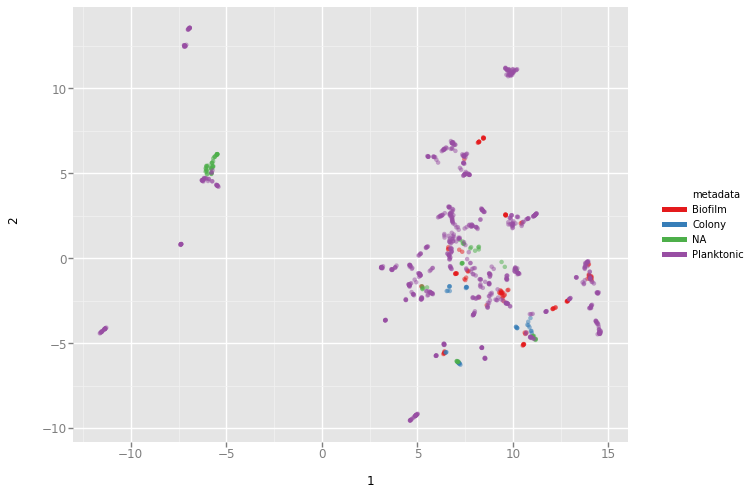

<ggplot: (8754511694961)>

In [13]:
# Plot
ggplot(aes(x='1',y='2', color='metadata'), data=embedding_df) + \
        geom_point(alpha=0.5) + \
        scale_color_brewer(type='qual', palette='Set1')
#ggMarginal(fig, type='histogram')

## Plot 0-1 normalized data

In [14]:
normalized_data_labeled = normalized_data.merge(
    metadata_selected_labeled, 
    left_index=True, 
    right_index=True,
    how='inner')

print(normalized_data_labeled.shape)
normalized_data_labeled.head(5)

(989, 5550)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570,growth_setting_1
05_PA14000-4-2_5-10-07_S2.CEL,0.853357,0.725280,0.640617,0.811465,0.694460,0.533958,0.158865,0.889579,0.884945,0.176558,...,0.702785,0.790965,0.893249,0.789939,0.164157,0.970470,0.887472,0.900484,0.880012,Planktonic
54375-4-05.CEL,0.778790,0.767873,0.614859,0.907865,0.398800,0.460849,0.113876,0.761351,0.801740,0.222709,...,0.694387,0.733186,0.639074,0.681204,0.110301,0.619554,0.747656,0.749893,0.805374,Planktonic
AKGlu_plus_nt_7-8-09_s1.CEL,0.789155,0.729508,0.725913,0.718989,0.530160,0.466327,0.079507,0.731643,0.827707,0.241847,...,0.700352,0.773422,0.791118,0.931585,0.172570,0.797148,0.753785,0.856253,0.811099,Planktonic
DB1.CEL,0.256216,0.461307,0.396341,0.430438,0.398933,0.379887,0.652586,0.569757,0.375272,0.225683,...,0.538515,0.572184,0.568535,0.556461,0.623840,0.970830,0.503223,0.692651,0.386309,Biofilm
DB3.CEL,0.320985,0.452921,0.231726,0.447838,0.335848,0.379614,0.252038,0.518413,0.441566,0.186477,...,0.544428,0.502996,0.429489,0.278100,0.541859,0.860111,0.533048,0.604709,0.433888,Biofilm


In [15]:
# UMAP embedding of raw gene space data
embedding_normalized = umap.UMAP().fit_transform(normalized_data_labeled.iloc[:,1:-1])
embedding_normalized_df = pd.DataFrame(data=embedding_normalized, columns=['1','2'])
embedding_normalized_df['metadata'] = list(normalized_data_labeled[metadata_field])
print(embedding_normalized_df.shape)
embedding_normalized_df.head(5)

/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/umap/spectral.py:229: UserWarning: Embedding 4 connected components using meta-embedding (experimental)
  n_components
/home/alexandra/anaconda3/envs/batch_effects/lib/python3.5/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(989, 3)


,1,2,metadata
0,11.566750,4.447729,Planktonic
1,6.942074,3.429366,Planktonic
2,11.598930,4.423634,Planktonic
3,6.290447,-0.394043,Biofilm
4,6.349319,-0.439417,Biofilm


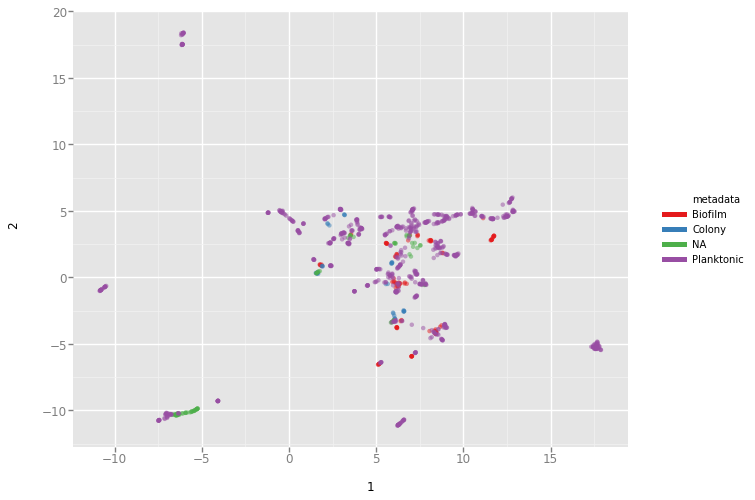

<ggplot: (-9223363282342626160)>

In [16]:
# Plot
ggplot(aes(x='1',y='2', color='metadata'), data=embedding_normalized_df) + \
    geom_point(alpha=0.5) + \
    scale_color_brewer(type='qual', palette='Set1')